# Analysis of DNA-MERFISH for CTP11,12,13

by Pu Zheng

2022.07.21

analysis for dataset:

* dna_data_folder = r'\\10.245.74.158\Chromatin_NAS_7\20220713-P_brain_CTP11-13_from_0418'

* rna_data_folder = r'\\10.245.74.158\Chromatin_NAS_0\20220418-P_brain_M1_nonclear_adaptors'

## in mendel
* save_folder = r'F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418' 


In [1]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..\..\..\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

72172


## 0.1 Folders

In [2]:
save_folder = r'F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418'
save_filenames = [os.path.join(save_folder, _fl) for _fl in os.listdir(save_folder)
                  if _fl.split(os.extsep)[-1]=='hdf5']
# extract fov_id
save_fov_ids = [int(os.path.basename(_fl).split('.hdf5')[0].split('_')[-1]) for _fl in save_filenames]

debug = False

print(f"{len(save_filenames)} fovs detected")

analysis_folder = os.path.join(save_folder, 'Analysis_0709')

segmentation_folder = os.path.join(analysis_folder, 'Segmentation')
if not os.path.exists(segmentation_folder):
    os.makedirs(segmentation_folder)
    print(f"Creating segmentation_folder: {segmentation_folder}")
else:
    print(f"Use segmentation_folder: {segmentation_folder}")

cand_spot_folder = os.path.join(analysis_folder, 'CandSpots')
if not os.path.exists(cand_spot_folder):
    os.makedirs(cand_spot_folder)
    print(f"Creating cand_spot_folder: {cand_spot_folder}")
else:
    print(f"Use cand_spot_folder: {cand_spot_folder}")

decoder_folder = cand_spot_folder.replace('CandSpots', 'Decoder')
if debug:
    _version = 0
    while os.path.exists(os.path.join(decoder_folder, f'v{_version}')):
        _version += 1
    decoder_folder = os.path.join(decoder_folder, f'v{_version}')
if not os.path.exists(decoder_folder):
    os.makedirs(decoder_folder)
    print(f"Creating decoder_folder: {decoder_folder}")
else:
    print(f"Use decoder_folder: {decoder_folder}")
    
picked_folder = os.path.join(analysis_folder, 'Picked_v0')
if not os.path.exists(picked_folder):
    os.makedirs(picked_folder)
    print(f"Creating picked_folder: {picked_folder}")
else:
    print(f"Use picked_folder: {picked_folder}")

184 fovs detected
Use segmentation_folder: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation
Use cand_spot_folder: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\CandSpots
Use decoder_folder: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Decoder
Use picked_folder: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Picked_v0


In [3]:
pixel_sizes = np.array([250,108,108])
single_im_size = np.array([50,2048,2048])

# 1. Partition DNA-MERFISH spots

In [4]:
from ImageAnalysis3.classes.partition_spots import Spots_Partition
from ImageAnalysis3.classes.preprocess import Spots3D
from ImageAnalysis3.figure_tools import plot_partition
import pandas as pd

In [5]:
from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
import ImageAnalysis3.io_tools.spots 

In [6]:
search_radius = 3
overwrite_cand_spots = False
add_relabel_spots = False
data_type = 'combo' # 'combo'
#_total_seg_save_file defined in 2.3
if not os.path.exists(os.path.join(cand_spot_folder, data_type)):
    print(os.path.join(cand_spot_folder, data_type))
    os.makedirs(os.path.join(cand_spot_folder, data_type))
# load microscope.json
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'

In [7]:
%%time
_partition_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):

    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    # savename
    _cand_spot_filename = os.path.join(cand_spot_folder, data_type, 
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(_cand_spot_filename) and not overwrite_cand_spots:
        continue
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', dna_microscope_file, np.array([]))
    _align_seg._load(_segmentation_savefile)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    # load spots
    spots_list, combo_bits = ia.io_tools.spots.load_preprocess_spots(
        _save_filename, data_type, None, pixel_sizes=pixel_sizes,
    )
    # add relabeled spots if specified.
    if add_relabel_spots:
        relabel_spots_list, relabel_bits = ia.io_tools.spots.load_preprocess_spots(
            _save_filename, f'relabeled_{data_type}', None, pixel_sizes=pixel_sizes,
        )
        for _rspots, _rbit in zip(relabel_spots_list, relabel_bits):
            _ind = list(combo_bits).index(_rbit)
            _old_spots = spots_list[_ind]
            # merge
            _merged_spots = ia.io_tools.spots.merge_RelabelSpots(
                _old_spots, _rspots, pixel_sizes=pixel_sizes,
            )
            # replace
            spots_list[_ind] = _merged_spots
    # 
    _all_spots = ia.io_tools.spots.merge_Spots3DList(spots_list, pixel_sizes=pixel_sizes)
    # partition args
    _args = (
        _fov_id, 
        np.array(_all_spots), _all_spots.bits, _all_spots.channels,
        seg_label, fovcell_2_uid,
        dna_microscope_file,
        search_radius, pixel_sizes,
        True, 
        True, _cand_spot_filename,
        True, 60, 
        False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

-- loading segmentation info from fov:6 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_006_Segmentation.hdf5
-- loading segmentation info from fov:7 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_007_Segmentation.hdf5
-- loading segmentation info from fov:8 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_008_Segmentation.hdf5
-- loading segmentation info from fov:9 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_009_Segmentation.hdf5
-- loading segmentation info from fov:10 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_010_Segmentation.hdf5
-- loading segmentation info from fov:11 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_011_Segmentation.hdf5
-- loading segmentation info from fov:12 into file

-- loading segmentation info from fov:60 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_060_Segmentation.hdf5
-- loading segmentation info from fov:61 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_061_Segmentation.hdf5
-- loading segmentation info from fov:62 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_062_Segmentation.hdf5
-- loading segmentation info from fov:63 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_063_Segmentation.hdf5
-- loading segmentation info from fov:64 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_064_Segmentation.hdf5
-- loading segmentation info from fov:65 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_065_Segmentation.hdf5
-- loading segmentation info from fov:66 into 

-- loading segmentation info from fov:118 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_118_Segmentation.hdf5
-- loading segmentation info from fov:119 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_119_Segmentation.hdf5
-- loading segmentation info from fov:120 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_120_Segmentation.hdf5
-- loading segmentation info from fov:122 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_122_Segmentation.hdf5
-- loading segmentation info from fov:123 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_123_Segmentation.hdf5
-- loading segmentation info from fov:125 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_125_Segmentation.hdf5
-- loading segmentation info from fov:12

-- loading segmentation info from fov:176 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_176_Segmentation.hdf5
-- loading segmentation info from fov:177 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_177_Segmentation.hdf5
-- loading segmentation info from fov:178 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_178_Segmentation.hdf5
-- loading segmentation info from fov:180 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_180_Segmentation.hdf5
-- loading segmentation info from fov:181 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_181_Segmentation.hdf5
-- loading segmentation info from fov:182 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_182_Segmentation.hdf5
-- loading segmentation info from fov:18

## 1.1 parallel process

In [8]:
%%time
import multiprocessing as mp
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(12) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(ia.classes.partition_spots.batch_partition_DNA_spots, 
                            _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 3355.008s. 
Wall time: 55min 55s


### 1.1.2 sequential version

- Partition cand_spots for fov:0
-- partition barcodes for 2149772 spots


2149772it [01:29, 24084.52it/s]


- Save 1446029 spots to file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\CandSpots\combo\Conv_zscan_000_CandSpots.csv


<IPython.core.display.Javascript object>


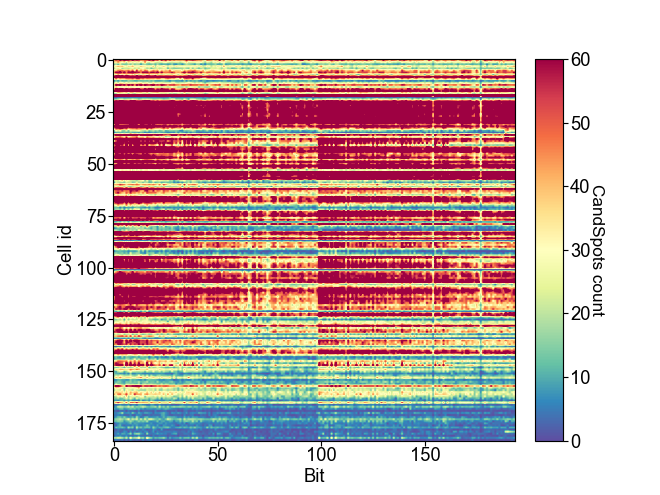

-- save iamage to file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\CandSpots\combo\Figures\Fov-0_SpotCountPerCell.png
-- finish partition in 244.483s. 


In [9]:
# sequential
for _args in _partition_args:
    ia.classes.partition_spots.batch_partition_DNA_spots(*_args)
    break

## Partition sequential genes

In [9]:
search_radius = 3
overwrite_cand_spots = False
add_relabel_spots = False
data_type = 'unique'
expect_spot_num = 4

#_total_seg_save_file defined in 2.3
if not os.path.exists(os.path.join(cand_spot_folder,data_type)):
    print(os.path.join(cand_spot_folder,data_type))
    os.makedirs(os.path.join(cand_spot_folder,data_type))
# load microscope.json
dna_microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'

F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\CandSpots\unique


In [10]:
%%time
_partition_args = []

for _fov_id, _save_filename in zip(save_fov_ids, save_filenames):

    _segmentation_savefile = os.path.join(segmentation_folder, 
        os.path.basename(_save_filename).replace('.hdf5', '_Segmentation.hdf5') )
    # savename
    _cand_spot_filename = os.path.join(cand_spot_folder, data_type, 
                                      os.path.basename(_save_filename).replace('.hdf5', f'_CandSpots.csv') )
    if os.path.isfile(_cand_spot_filename) and not overwrite_cand_spots:
        continue
    # load segmentation label matrix and uids
    _align_seg = Align_Segmentation('', '', _save_filename, '', dna_microscope_file, np.array([]))
    _align_seg._load(_segmentation_savefile)
    seg_label, fovcell_2_uid = _align_seg.dna_mask, _align_seg.fovcell_2_uid
    # load spots
    spots_list, combo_bits = ia.io_tools.spots.load_preprocess_spots(
        _save_filename, data_type, None, pixel_sizes=pixel_sizes,
    )
    # add relabeled spots if specified.
    if add_relabel_spots:
        relabel_spots_list, relabel_bits = ia.io_tools.spots.load_preprocess_spots(
            _save_filename, f'relabeled_{data_type}', None, pixel_sizes=pixel_sizes,
        )
        for _rspots, _rbit in zip(relabel_spots_list, relabel_bits):
            _ind = list(combo_bits).index(_rbit)
            _old_spots = spots_list[_ind]
            # merge
            _merged_spots = ia.io_tools.spots.merge_RelabelSpots(
                _old_spots, _rspots, pixel_sizes=pixel_sizes,
            )
            # replace
            spots_list[_ind] = _merged_spots
    # 
    _all_spots = ia.io_tools.spots.merge_Spots3DList(spots_list, pixel_sizes=pixel_sizes)
    # partition args
    _args = (
        _fov_id, 
        np.array(_all_spots), _all_spots.bits, _all_spots.channels,
        seg_label, fovcell_2_uid,
        dna_microscope_file,
        search_radius, pixel_sizes,
        True, 
        True, _cand_spot_filename,
        True, expect_spot_num, 
        False, True,
    )
    _partition_args.append(_args)
    
print(len(_partition_args))

-- loading segmentation info from fov:0 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_000_Segmentation.hdf5
-- loading segmentation info from fov:1 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_001_Segmentation.hdf5
-- loading segmentation info from fov:2 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_002_Segmentation.hdf5
-- loading segmentation info from fov:3 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_003_Segmentation.hdf5
-- loading segmentation info from fov:4 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_004_Segmentation.hdf5
-- loading segmentation info from fov:5 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_005_Segmentation.hdf5
-- loading segmentation info from fov:6 into file: F

-- loading segmentation info from fov:54 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_054_Segmentation.hdf5
-- loading segmentation info from fov:55 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_055_Segmentation.hdf5
-- loading segmentation info from fov:56 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_056_Segmentation.hdf5
-- loading segmentation info from fov:57 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_057_Segmentation.hdf5
-- loading segmentation info from fov:58 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_058_Segmentation.hdf5
-- loading segmentation info from fov:59 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_059_Segmentation.hdf5
-- loading segmentation info from fov:60 into 

-- loading segmentation info from fov:111 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_111_Segmentation.hdf5
-- loading segmentation info from fov:112 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_112_Segmentation.hdf5
-- loading segmentation info from fov:113 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_113_Segmentation.hdf5
-- loading segmentation info from fov:114 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_114_Segmentation.hdf5
-- loading segmentation info from fov:116 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_116_Segmentation.hdf5
-- loading segmentation info from fov:117 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_117_Segmentation.hdf5
-- loading segmentation info from fov:11

-- loading segmentation info from fov:169 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_169_Segmentation.hdf5
-- loading segmentation info from fov:171 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_171_Segmentation.hdf5
-- loading segmentation info from fov:172 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_172_Segmentation.hdf5
-- loading segmentation info from fov:173 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_173_Segmentation.hdf5
-- loading segmentation info from fov:174 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_174_Segmentation.hdf5
-- loading segmentation info from fov:175 into file: F:\Pu_Temp\20220713-P_brain_CTP11-13_from_0418\Analysis_0709\Segmentation\Conv_zscan_175_Segmentation.hdf5
-- loading segmentation info from fov:17

In [11]:
%%time
import multiprocessing as mp
# Multiprocessing
print(f"- Start multiprocessing spot partitioning", end=' ')
_start_time = time.time()
with mp.Pool(12) as _partition_pool:
    # start multiprocessing
    _partition_pool.starmap(ia.classes.partition_spots.batch_partition_DNA_spots, 
                            _partition_args, chunksize=1)
    # close multiprocessing
    _partition_pool.close()
    _partition_pool.join()
    _partition_pool.terminate()
print(f"finish in {time.time()-_start_time:.3f}s. ")

- Start multiprocessing spot partitioning finish in 299.337s. 
Wall time: 4min 59s


### 1.2.2 sequential version

In [ ]:
# sequential
for _args in _partition_args[]:
    ia.classes.partition_spots.batch_partition_DNA_spots(*_args)
    break